In [7]:

import numpy as np
import astropy.units as u
from astropy.io import fits
import copy

import poppy

import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

wavelength = 633*u.nm
fsm_pupil_diam = 4*u.mm
fl = 200*u.mm
relay_fl = 200*u.mm
zwfs_pupil_diam =  fsm_pupil_diam * relay_fl/fl
zwfs_pxscl = 3.45*u.um
fnum = (fl/fsm_pupil_diam).decompose().value
as_per_lamD = ((wavelength/fsm_pupil_diam).decompose() * u.radian).to(u.arcsec)
print(zwfs_pupil_diam)
print(fnum)
print(as_per_lamD)

npix = int((zwfs_pupil_diam/zwfs_pxscl).decompose().value)
print(npix)


4.0 mm
50.0
32.64140558860301 arcsec
1159


In [ ]:
# npix = 256
oversample = 8
N = int(npix*oversample)

pwf = poppy.FresnelWavefront(beam_radius=fsm_pupil_diam/2, npix=npix, oversample=oversample) # pupil wavefront
ap = poppy.CircularAperture(radius=fsm_pupil_diam/2).get_transmission(pwf)
mask = ap.astype(bool)
tt_modes = poppy.zernike.arbitrary_basis(ap, nterms=3, outside=0)[1:]

zwfs_pixelscale_lamD = 1/oversample
y,x = (xp.indices((N, N)) - N//2)*zwfs_pixelscale_lamD
r = xp.sqrt(x**2 + y**2)
M = r<1.06/2
zwfs_mask = xp.exp(1j * xp.pi/2 * M)
imshow2(M, xp.angle(zwfs_mask), npix=64)

def fft(arr):
    return xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(arr)))

def ifft(arr):
    return xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(arr)))

def snap_zwfs(pupil, use_zwfs=True):
    fpwf = fft(pupil)
    fpwf *= zwfs_mask if use_zwfs else 1
    ppwf = ifft(fpwf)
    return xp.abs(ppwf)**2

In [1]:
!nvidia-smi


Wed Aug  7 08:56:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:25:00.0 Off |                    0 |
| N/A   34C    P0             64W /  300W |   38372MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

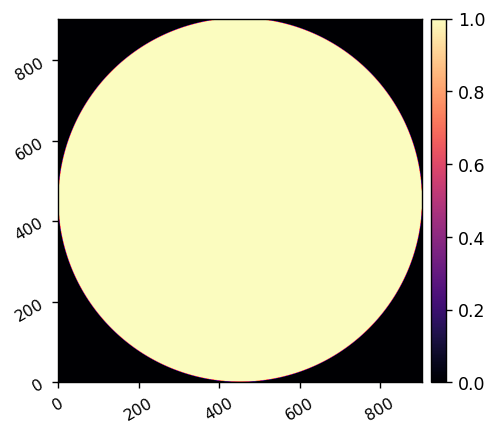

In [21]:
P = snap_zwfs(ap, use_zwfs=False)
imshow1(P, npix=npix)

In [22]:
b = ifft(M * fft(ap))

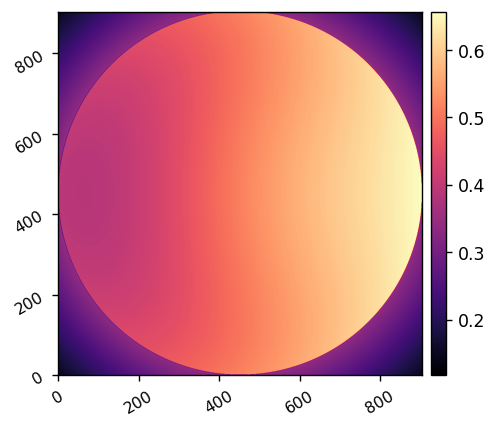

In [23]:
# Ic = snap_zwfs(ap)

amp = 10e-9
Ic = snap_zwfs(ap * xp.exp(1j * 2*xp.pi / wavelength.to_value(u.m) * amp * tt_modes[0] ))
imshow1(Ic, npix=npix)

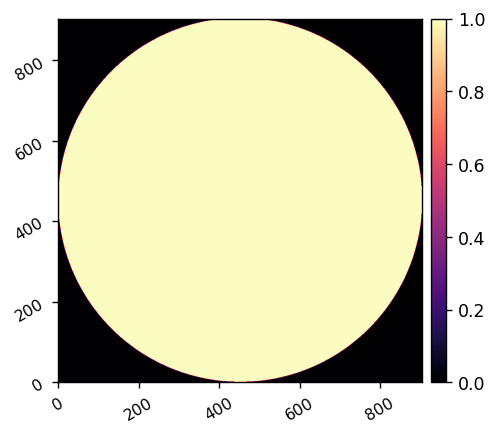

9.026287481414795e-09


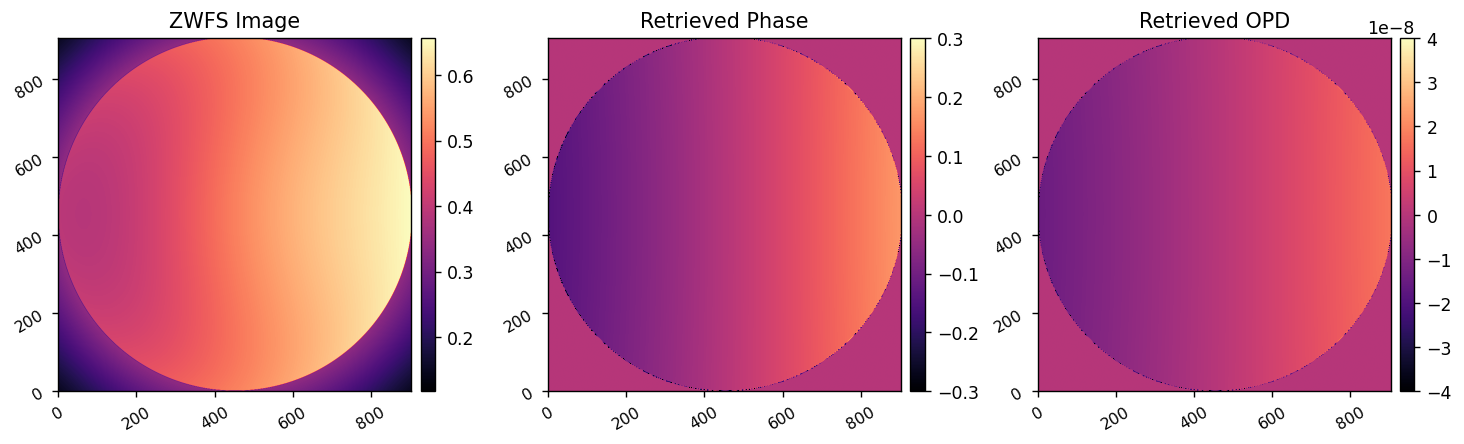

In [19]:
phi = ( Ic - P**2 - 2*b**2 + 2*P*b ) / (2*P*b)

opd = phi.real * wavelength.to_value(u.m)/(2*np.pi)

# data_mask = (Ic > 0.35) * mask
data_mask = (xp.abs(opd) < 2.5e-7) * mask
imshow1(data_mask, npix=npix)

rms = xp.sqrt(xp.mean(xp.square(opd[data_mask])))
print(rms)

# imshow2(phi.real, opd* data_mask, npix=npix, 
#         vmin1=-vmax1, vmax1=vmax1,
#         vmin2=-vmax2, vmax2=vmax2)

vmax2 = 0.3
vmax3 = 40e-9
imshow3(Ic, phi.real * data_mask, opd* data_mask,
        'ZWFS Image', 'Retrieved Phase', 'Retrieved OPD',
        npix=npix, 
        vmin2=-vmax2, vmax2=vmax2, 
        vmin3=-vmax3, vmax3=vmax3,
        )

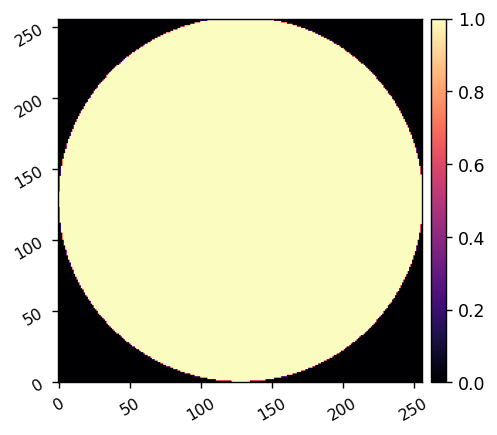

In [39]:
data_mask = (xp.abs(opd) < 1e-7) * mask
imshow1(data_mask, npix=npix)
rms = xp.sqrt(xp.mean(xp.square(opd[data_mask])))

array(8.64407833e-09)